In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2025-06-11 01:54:56.903158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749606897.093339      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749606897.149577      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the path to the dataset (adjust as per your Kaggle environment)
output_path = '/kaggle/input/thesis-dataset-v4'  # Update this path as needed

Lung_Opacity - 1.jpg: Shape = (299, 299, 3)
Normal - 1.jpg: Shape = (299, 299, 3)
Viral Pneumonia - 1.jpg: Shape = (299, 299, 3)


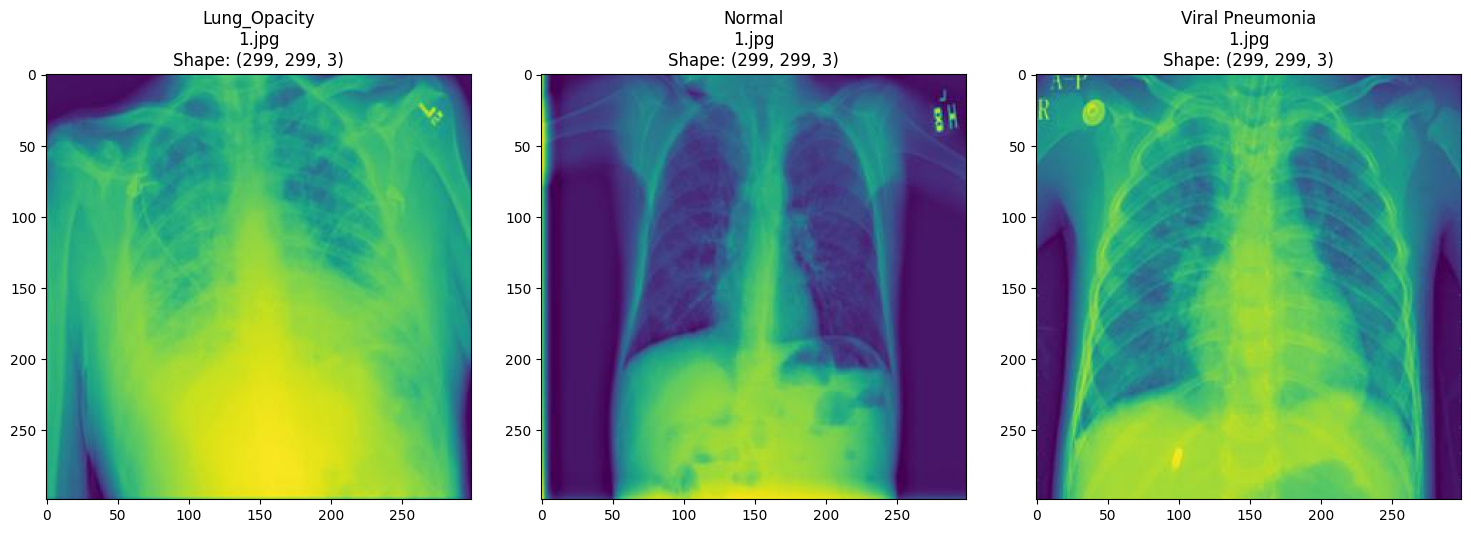

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Base path
base_path = '/kaggle/input/thesis-dataset-v4/train'

# Define the folders
folders = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Create a figure with subplots for all three images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, folder in enumerate(folders):
    folder_path = os.path.join(base_path, folder)
    
    # Get the first image from the folder
    if os.path.exists(folder_path):
        # List all files in the folder
        files = sorted(os.listdir(folder_path))
        
        # Find the first image file
        image_file = None
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_file = file
                break
        
        if image_file:
            # Full path to the image
            image_path = os.path.join(folder_path, image_file)
            
            # Open and convert to array
            img = Image.open(image_path)
            img_array = np.array(img)
            
            # Display the image
            axes[idx].imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
            axes[idx].set_title(f'{folder}\n{image_file}\nShape: {img_array.shape}')
            axes[idx].axis('on')
            
            # Print shape information
            print(f"{folder} - {image_file}: Shape = {img_array.shape}")
        else:
            print(f"No images found in {folder}")
    else:
        print(f"Folder {folder} not found")

plt.tight_layout()
plt.show()

In [4]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 3  # Lung-Opacity, Normal, Viral Pneumonia
EPOCHS = 50

In [5]:
# Step 1: Data Loading and Preprocessing
# Define data augmentation and preprocessing for training
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  
)

# Training data generator
train_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    os.path.join(output_path, 'train'),  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' 
)

# Test data generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(output_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1946 images belonging to 3 classes.
Found 484 images belonging to 3 classes.
Found 350 images belonging to 3 classes.


In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, multiply, Dense, Activation

def se_block(input_tensor, ratio=16):
    channel_axis = -1  # For 'channels_last'
    filters = input_tensor.shape[channel_axis]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return multiply([input_tensor, se])


I0000 00:00:1749606912.070380      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749606912.071129      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Base model (InceptionV3) output shape: (None, 5, 5, 2048)
After SE-block shape: (None, 5, 5, 2048)
After GlobalAveragePooling2D shape: (None, 2048)
After Dense(512) shape: (None, 512)
After BatchNormalization shape: (None, 512)
After Dropout(0.5) shape: (None, 512)
After Dense(256) shape: (None, 256)
After BatchNormalization shape: (None, 256)
After Dropout(0.3) shape: (None, 256)
After Dense(NUM_CLASSES) output shape: (None, 3)

MODEL SUMMARY:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,511,331 (89.69 MB)

 Trainable params: 23,475,363 (89.55 MB)

 Non-trainable params: 35,968 (140.50 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749606974.804923      84 service.cc:148] XLA service 0x7b943c015ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749606974.805770      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749606974.805794      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749606980.504503      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749607014.127379      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

61/61 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5603 - loss: 2.2824 - val_accuracy: 0.7603 - val_loss: 1.8686
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.8284 - loss: 1.6122 - val_accuracy: 0.8079 - val_loss: 1.7204
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 470ms/step - accuracy: 0.8696 - loss: 1.5013 - val_accuracy: 0.8802 - val_loss: 1.5174
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.8771 - loss: 1.4542 - val_accuracy: 0.8616 - val_loss: 1.5209
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.9122 - loss: 1.4146 - val_accuracy: 0.8822 - val_loss: 1.4137
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.8868 - loss: 1.4128 - val_accuracy: 0.9070 - val_loss: 1.3742
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 462ms/step - accuracy: 0.8945 - loss: 1.3987 - val_accuracy: 0.9153 - val_loss: 1.3338
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.9121 - loss: 1.3496 - val_accuracy: 0.9029 

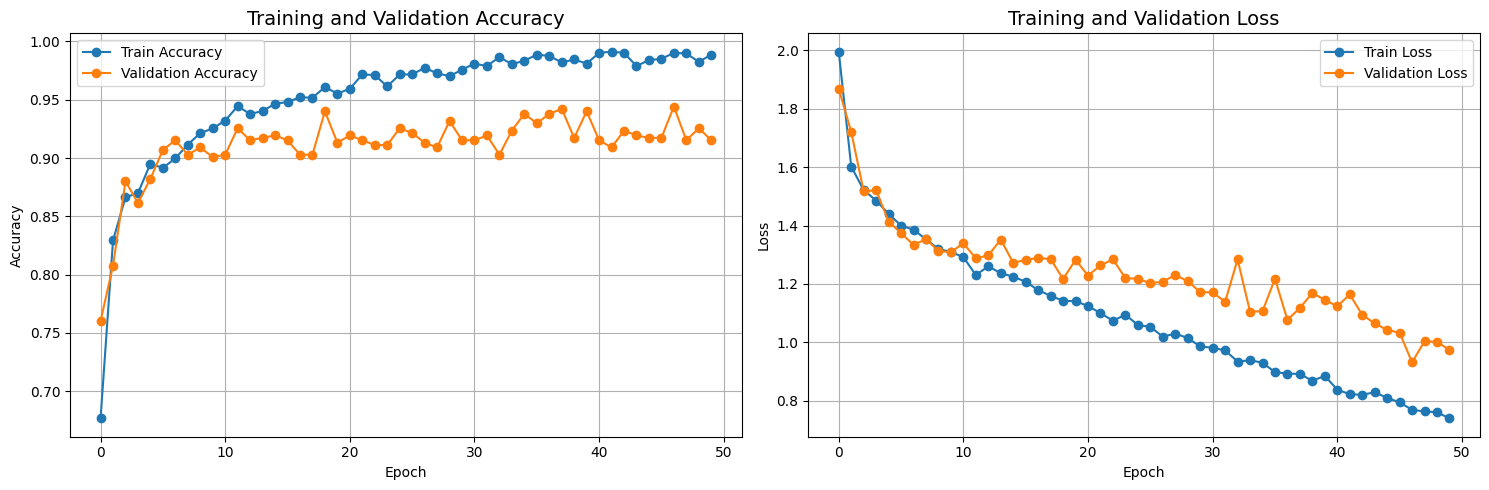


FEATURE EXTRACTION:
Total number of layers in model: 324
Layer at index -3: batch_normalization_95
Layer at index -3 type: <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
Output shape of layer -3: (None, 256)
Feature Vector Shape: (None, 256)

Last 5 layers of the model:
Layer -5: dropout - Type: Dropout - Output shape: (None, 512)
Layer -4: dense_3 - Type: Dense - Output shape: (None, 256)
Layer -3: batch_normalization_95 - Type: BatchNormalization - Output shape: (None, 256)
Layer -2: dropout_1 - Type: Dropout - Output shape: (None, 256)
Layer -1: dense_4 - Type: Dense - Output shape: (None, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

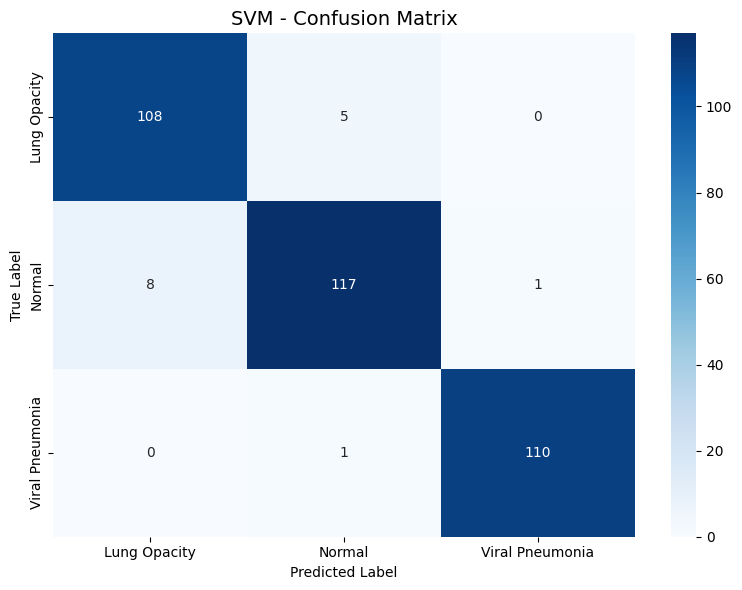


Training Random Forest...
Random Forest Test Accuracy: 95.43%

                 precision    recall  f1-score   support

   Lung Opacity       0.92      0.96      0.94       113
         Normal       0.96      0.91      0.93       126
Viral Pneumonia       0.98      1.00      0.99       111

       accuracy                           0.95       350
      macro avg       0.95      0.96      0.96       350
   weighted avg       0.95      0.95      0.95       350



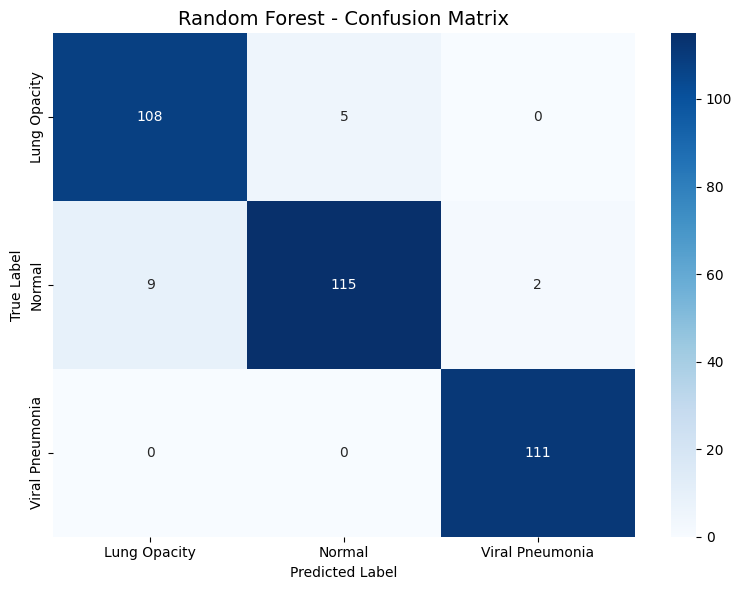


Training XGBoost...
XGBoost Test Accuracy: 95.14%

                 precision    recall  f1-score   support

   Lung Opacity       0.91      0.96      0.94       113
         Normal       0.97      0.90      0.93       126
Viral Pneumonia       0.98      0.99      0.99       111

       accuracy                           0.95       350
      macro avg       0.95      0.95      0.95       350
   weighted avg       0.95      0.95      0.95       350



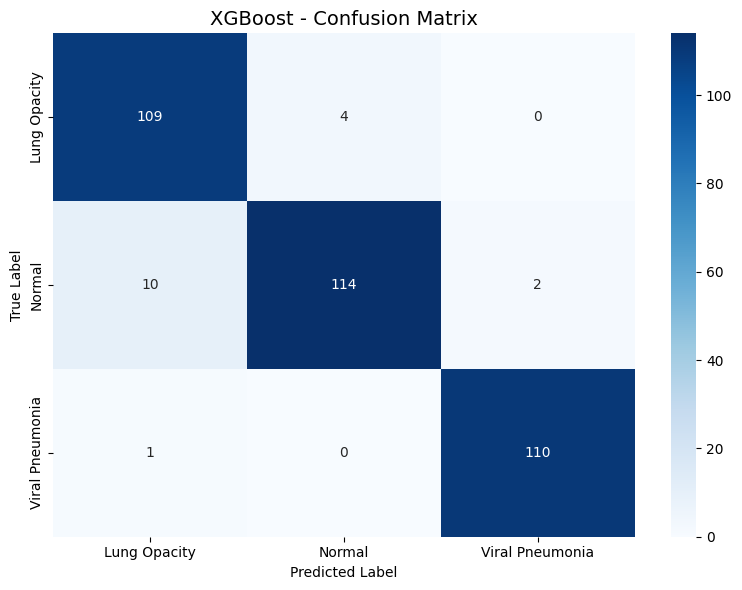

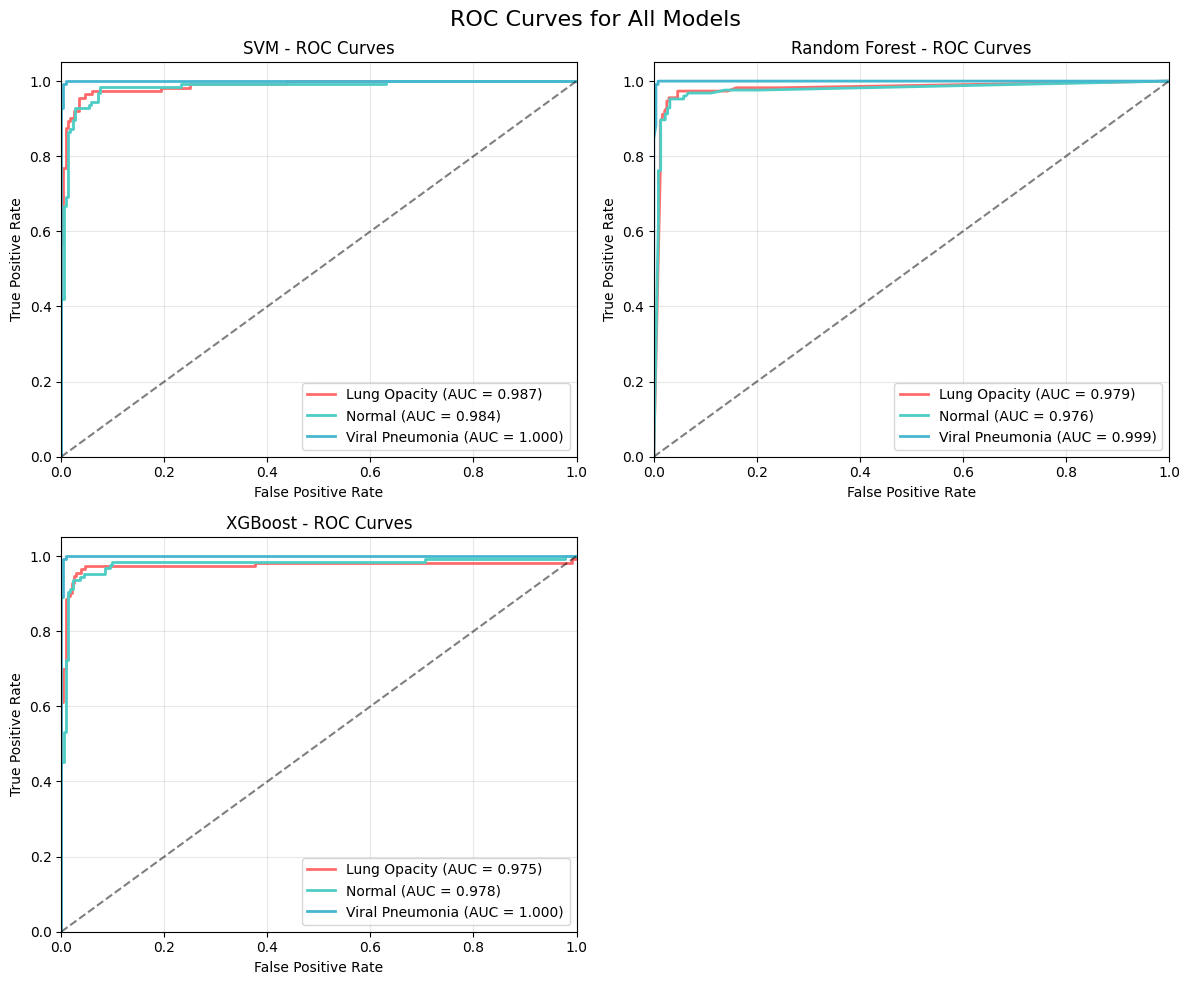

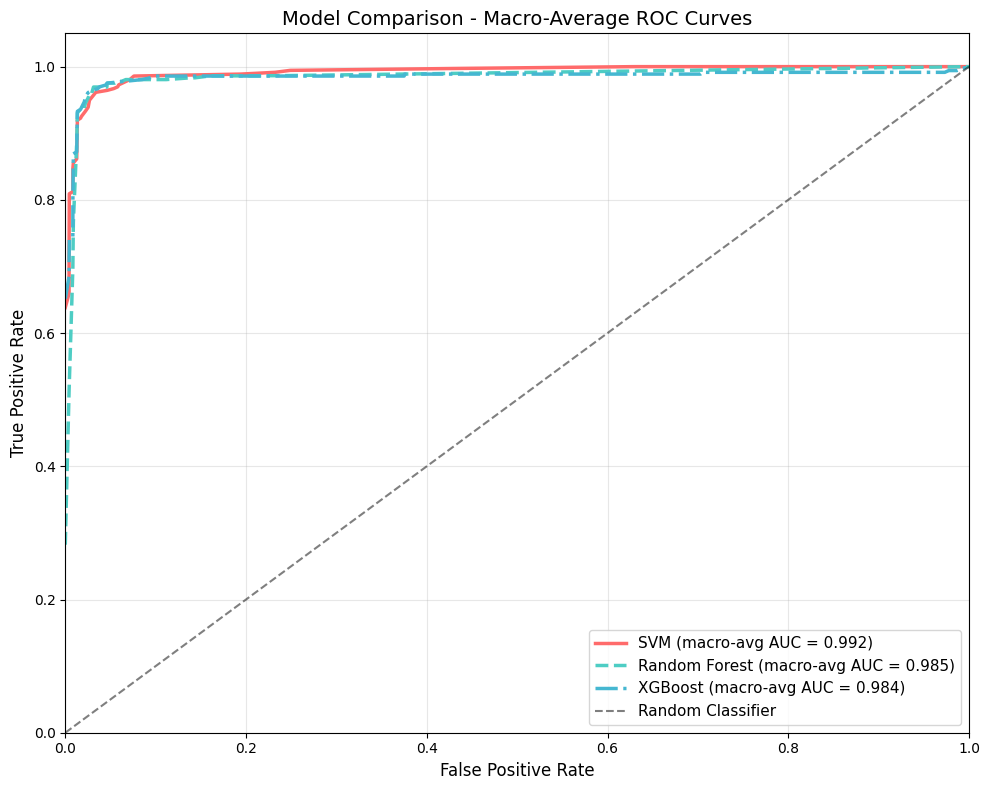


SUMMARY OF ALL MODELS
SVM: 95.71%
Random Forest: 95.43%
XGBoost: 95.14%


In [7]:
# Step 2: Build and Train InceptionV3 Model with Enhanced Custom Layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Define class names
class_names = {0: 'Lung Opacity', 1: 'Normal', 2: 'Viral Pneumonia'}
class_labels = ['Lung Opacity', 'Normal', 'Viral Pneumonia']

# Print base model output shape
print(f"Base model (InceptionV3) output shape: {base_model.output.shape}")

# Apply SE block
x = se_block(base_model.output)  # Channel attention here
print(f"After SE-block shape: {x.shape}")

# Continue with dense layers
x = GlobalAveragePooling2D()(x)
print(f"After GlobalAveragePooling2D shape: {x.shape}")

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
print(f"After Dense(512) shape: {x.shape}")

x = BatchNormalization()(x)
print(f"After BatchNormalization shape: {x.shape}")

x = Dropout(0.5)(x)
print(f"After Dropout(0.5) shape: {x.shape}")

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
print(f"After Dense(256) shape: {x.shape}")

x = BatchNormalization()(x)
print(f"After BatchNormalization shape: {x.shape}")

x = Dropout(0.3)(x)
print(f"After Dropout(0.3) shape: {x.shape}")

outputs = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(0.001))(x)
print(f"After Dense(NUM_CLASSES) output shape: {outputs.shape}")

# Build model
model = Model(inputs=base_model.input, outputs=outputs)

# Print model summary to see all layers
print("\n" + "="*50)
print("MODEL SUMMARY:")
print("="*50)
model.summary()

for layer in base_model.layers[-40:]:
    layer.trainable = True

from tensorflow.keras.losses import CategoricalCrossentropy

# Compile with label smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Step 3: Plot Training and Validation Accuracy AND Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax1.set_title('Training and Validation Accuracy', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax2.set_title('Training and Validation Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('cnn_training_curves.png', dpi=300)
plt.show()

# Step 4: Extract Features Using the CNN
print("\n" + "="*50)
print("FEATURE EXTRACTION:")
print("="*50)

# Print information about the layer we're extracting features from
print(f"Total number of layers in model: {len(model.layers)}")
print(f"Layer at index -3: {model.layers[-3].name}")
print(f"Layer at index -3 type: {type(model.layers[-3])}")
print(f"Output shape of layer -3: {model.layers[-3].output.shape}")

feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
feature_extractor.save('feature_extractor_model.h5')
print(f"Feature Vector Shape: {feature_extractor.output_shape}")

# Let's also print what each of the last few layers are
print("\nLast 5 layers of the model:")
for i in range(-5, 0):
    layer = model.layers[i]
    print(f"Layer {i}: {layer.name} - Type: {type(layer).__name__} - Output shape: {layer.output.shape}")

def extract_features(generator):
    features, labels = [], []
    for _ in range(len(generator)):
        X_batch, y_batch = next(generator)
        batch_features = feature_extractor.predict(X_batch)
        features.extend(batch_features)
        labels.extend(np.argmax(y_batch, axis=1))
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(val_generator)
X_test, y_test = extract_features(test_generator)

print(f"\nExtracted feature shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# Step 5: Train and Evaluate Classifiers (SVM, Random Forest, XGBoost)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

models = {
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Store results for ROC curves
results = {}

for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Get prediction probabilities for ROC curve
    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test)
    else:
        # For SVM with probability=True
        y_score = clf.decision_function(X_test)
        # Convert decision function to probabilities for multi-class
        from scipy.special import softmax
        y_score = softmax(y_score, axis=1)
    
    # Store results
    results[name] = {
        'y_pred': y_pred,
        'y_score': y_score,
        'accuracy': accuracy_score(y_test, y_pred) * 100
    }
    
    # Print accuracy
    acc = results[name]['accuracy']
    print(f"{name} Test Accuracy: {acc:.2f}%\n")
    
    # Classification report with custom labels
    print(classification_report(y_test, y_pred, target_names=class_labels))
    
    # Confusion Matrix with custom labels
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{name} - Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f'{name}_confusion_matrix.png', dpi=300)
    plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(12, 10))

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

for model_idx, (name, result) in enumerate(results.items()):
    y_score = result['y_score']
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.subplot(2, 2, model_idx + 1)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for i, (class_label, color) in enumerate(zip(class_labels, colors)):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_label} (AUC = {roc_auc[i]:.3f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curves', fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

# Add overall title
plt.suptitle('ROC Curves for All Models', fontsize=16)
plt.tight_layout()
plt.savefig('all_models_roc_curves.png', dpi=300)
plt.show()

# Plot combined ROC curves (macro-average) for model comparison
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
linestyles = ['-', '--', '-.']

for (name, result), color, ls in zip(results.items(), colors, linestyles):
    y_score = result['y_score']
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score[:, i])[0] 
                                       for i in range(NUM_CLASSES)]))
    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    
    mean_tpr /= NUM_CLASSES
    macro_auc = auc(all_fpr, mean_tpr)
    
    plt.plot(all_fpr, mean_tpr, color=color, linestyle=ls, lw=2.5,
             label=f'{name} (macro-avg AUC = {macro_auc:.3f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Model Comparison - Macro-Average ROC Curves', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_roc.png', dpi=300)
plt.show()

# Print summary of all models
print("\n" + "="*50)
print("SUMMARY OF ALL MODELS")
print("="*50)
for name, result in results.items():
    print(f"{name}: {result['accuracy']:.2f}%")